## Part 1) Choice of Data Source

> Note, this notebook is licensed [CC-BY 4.0](../LICENSE-CC-BY)

Let ut use the `human_mitosis` dataset that comes with the [skimage library](https://github.com/scikit-image/scikit-image). It is a uint8 fluorescence microscopy image stored in a standardized NumPy array format. The image shows human cells undergoing mitosis, captured using a DNA-binding dye that highlights the nuclei. Some interesting features about the image: shape (512, 512), dtype `uint8`, size 256.0 kB, min 7, max	255.

Let us note that although this dataset is widely used for testing segmentation algorithms, it does not come with a standardized metadata format such as OME-TIFF or DICOM. The image is embedded directly in the Python package and does not include associated acquisition parameters like time, channel information, or voxel size. You can find the dataset in the skimage.data module.

Let us also be aware of a few quirks:

- The image is already contrast-enhanced, which may not reflect raw microscopy data.
- There is no ground truth segmentation or annotation, so labeling or classification tasks require additional manual or automated preprocessing
- The background intensity is nonzero (minimum pixel value is 7), which can affect naive thresholding methods.

Let us cite the dataset according to the general scikit-image citation guideline:

> Van der Walt, S., Schönberger, J.L., Nunez-Iglesias, J. et al. scikit-image: image processing in Python. PeerJ 2, e453 (2014). https://doi.org/10.7717/peerj.453

## Part 2) Choice of Frameworks

The libraries were selected to ensure a smooth and efficient processing pipeline across image loading, segmentation, feature extraction, clustering, and visualization.
The primary data structure shared across tools was the NumPy array, allowing for seamless integration. Images and features were passed between libraries with minimal conversion.
In cases where format mismatches occurred, appropriate conversion functions (e.g., `.astype()` or DataFrame constructors) were used to ensure compatibility.

| Library                  | Purpose                                  | Benefits                                                                 | Drawbacks                                                              | Interoperability                          |
|--------------------------|------------------------------------------|--------------------------------------------------------------------------|------------------------------------------------------------------------|--------------------------------------------|
| **KMeans**               | Clustering                               | Simple and fast, easy to interpret                                      | Assumes spherical clusters                                             | Directly usable on feature DataFrames      |
| **Matplotlib**           | Static plotting                          | Highly customizable, publication quality                                | Verbose syntax                                                        | Forms the base for other plotting libs     |
| **NumPy**                | Numerical computations                   | Fast, array-based operations, widely supported                          | Low-level syntax for complex tasks                                    | Core data structure for most other tools   |
| **Pandas**               | Tabular data manipulation                | Intuitive API, integrates well with NumPy and plotting libraries        | Can be slow for very large datasets                                   | Works seamlessly with NumPy and Seaborn    |
| **Seaborn**              | Statistical plotting                     | Easy, beautiful plots with few lines of code                            | Less flexible than Matplotlib for complex layouts                     | Built on top of Matplotlib and Pandas      |
| **skimage**              | Image I/O, preprocessing, and features   | Pythonic, science-focused, good documentation                           | Slower than OpenCV for real-time tasks                                | Central to the image-processing pipeline   |
| **skimage.regionprops** | Feature extraction                       | Easy access to geometric and intensity metrics                          | Limited to basic features                                              | Returns results usable by Pandas/KMeans    |
| **sklearn**              | Classification and evaluation metrics    | Wide range of tools for ML, validation, and evaluation                  | Can be a bit of a black box if not used carefully                     | Works with NumPy/Pandas; integrates with pipelines |
| **StackView**            | Interactive image stack viewing          | Simple and lightweight interface for multidimensional data              | Limited customization                                                  | Accepts NumPy arrays directly              |
| **StarDist**             | Nuclei segmentation                      | State-of-the-art accuracy, deep learning based                          | Requires trained model, GPU for speed                                 | Outputs NumPy arrays compatible downstream |
| **UMAP**                 | Dimensionality reduction                 | Preserves data structure well, scalable                                 | Stochastic output can vary                                            | Input/output as NumPy/Pandas               |

In [ ]:
# general
import numpy as np
import pandas as pd

# image loading
from skimage import data
from skimage.io import imread

# preprocessing
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.transform import resize

# segmentation
from skimage.measure import label
from stardist.models import StarDist2D

# feature extraction
from skimage.measure import regionprops

# clustering 
import umap
from sklearn.cluster import KMeans

# visualization
import stackview
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# quality assurance
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

If you want to know the specific version of the libraries used in this notebook, please refer to the `requirements.txt` file.

## Part 3) Loading the Data

StackViewNDArray([[ 8,  8,  8, ..., 63, 78, 75],
                  [ 8,  8,  7, ..., 67, 71, 71],
                  [ 9,  8,  8, ..., 53, 64, 66],
                  ...,
                  [ 8,  9,  8, ..., 17, 24, 59],
                  [ 8,  8,  8, ..., 17, 22, 55],
                  [ 8,  8,  8, ..., 16, 18, 38]], dtype=uint8)
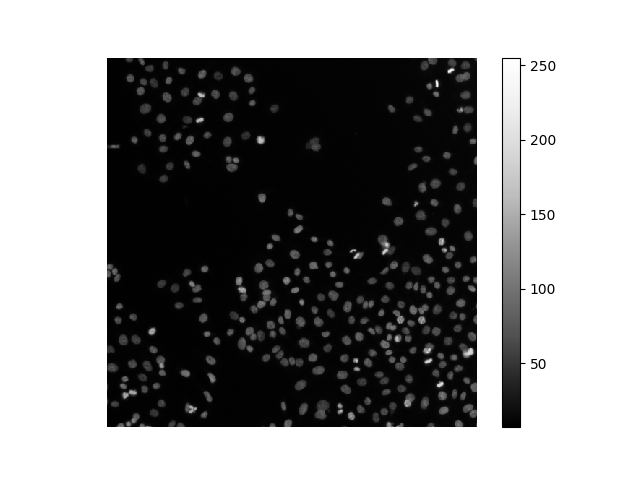
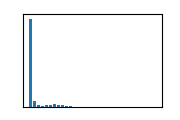

In [2]:
image = data.human_mitosis()

stackview.insight(image)

As we are looking at mitotic cells, we can formulate the following hypothesis:

__Hypothesis:__ The mitotic phase can be characterized using intensity-, size- and shape-based measurements.

## Part 4) Cleaning the data

As we are looking at an image here, we need to perform some preprocessing as well as segmentation for feature extraction

StackViewNDArray([[0.03147407, 0.0312145 , 0.03101078, ..., 0.23563382,
                   0.27485459, 0.28743902],
                  [0.03201622, 0.03138104, 0.03090503, ..., 0.22507952,
                   0.26146368, 0.27447849],
                  [0.03279859, 0.03211894, 0.03160971, ..., 0.20237295,
                   0.24003942, 0.25731509],
                  ...,
                  [0.03189504, 0.03200721, 0.03150998, ..., 0.07650608,
                   0.1202781 , 0.17720847],
                  [0.03161322, 0.0317396 , 0.03148758, ..., 0.07409934,
                   0.11242074, 0.16363831],
                  [0.0314237 , 0.03144408, 0.03127161, ..., 0.07003586,
                   0.0999463 , 0.14088554]])
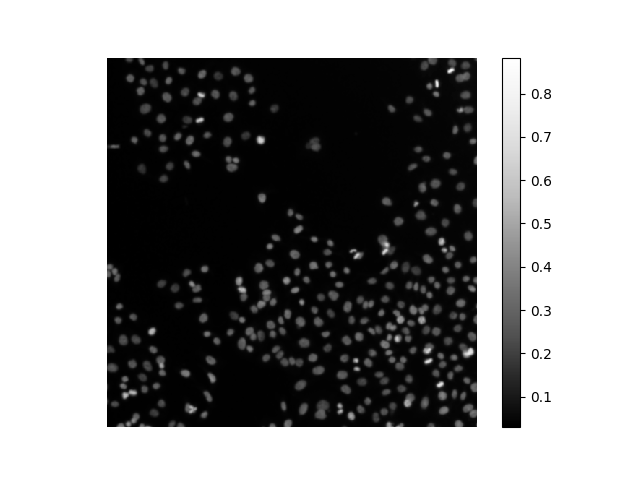
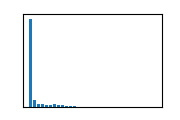

In [3]:
# Gaussian blur
image_gaussian = gaussian(image, sigma=1)
stackview.insight(image_gaussian)

_static_view.py (101): Converting input from bool to <class 'numpy.uint8'> for compatibility.


StackViewNDArray([[False, False, False, ...,  True,  True,  True],
                  [False, False, False, ...,  True,  True,  True],
                  [False, False, False, ...,  True,  True,  True],
                  ...,
                  [False, False, False, ..., False, False,  True],
                  [False, False, False, ..., False, False,  True],
                  [False, False, False, ..., False, False, False]])
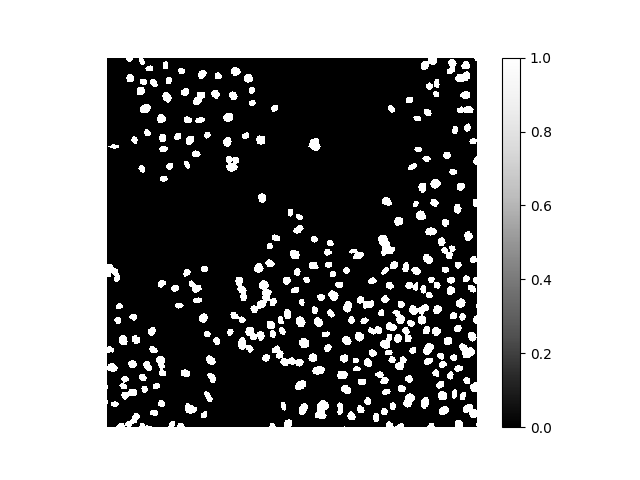
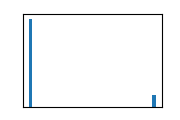

In [4]:
#threshold otsu
thresh = threshold_otsu(image_gaussian)
image_binary = image_gaussian > thresh
stackview.insight(image_binary)

StackViewNDArray([[  0,   0,   0, ...,   5,   5,   5],
                  [  0,   0,   0, ...,   5,   5,   5],
                  [  0,   0,   0, ...,   5,   5,   5],
                  ...,
                  [  0,   0,   0, ...,   0,   0, 275],
                  [  0,   0,   0, ...,   0,   0, 275],
                  [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)
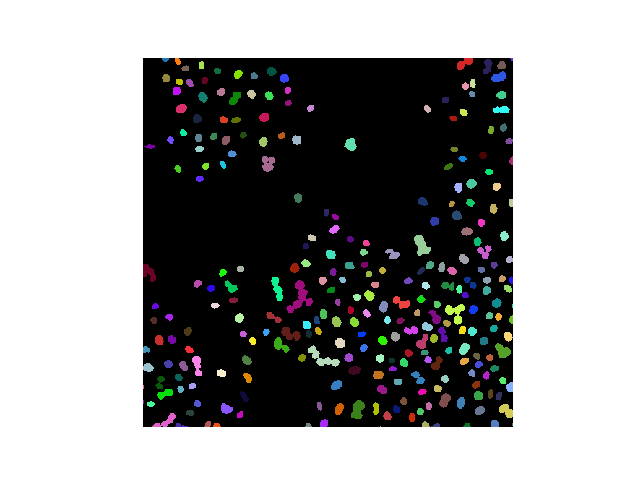

In [5]:
# Voronoi Otsu Labeling
img_labeled = label(image_binary)
stackview.insight(img_labeled)


Many dense nuclei are merged, so let us try out stardist here.

In [6]:
# Load a pre-trained 2D model (Versatile Fluorescent Nuclei)
model = StarDist2D.from_pretrained('2D_versatile_fluo')

# Run prediction
labels, _ = model.predict_instances(image_gaussian)

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


functional.py (238): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, 512, 512, 1))


Instead of visualizing the image with the labels side-by-side, let us try to use a curtain as it is more intuitive for images:

In [7]:
stackview.curtain(image, labels)

This looks way better!

In [8]:
properties = regionprops(labels, intensity_image=image)

In [9]:
statistics = {
    'area':       [p.area               for p in properties],
    'mean':       [p.mean_intensity     for p in properties],
    'min':        [p.min_intensity      for p in properties],
    'max':        [p.max_intensity      for p in properties],
    'major_axis': [p.major_axis_length  for p in properties],
    'minor_axis': [p.minor_axis_length for p in properties],
    'centroid':   [p.centroid for p in properties],
    'coords':     [p.coords for p in properties],
    'eccentricity': [p.eccentricity for p in properties],
    'solidity': [p.solidity for p in properties],
    'extent': [p.extent for p in properties],
    'perimeter': [p.perimeter for p in properties],
    'equivalent_diameter': [p.equivalent_diameter for p in properties],
}

df = pd.DataFrame(statistics)

# Add new columns interesting for determining mitotic phases
df['condensation_ratio'] = df['max'] / df['mean']

# View the updated DataFrame
df.head()

,area,mean,min,max,major_axis,minor_axis,centroid,coords,eccentricity,solidity,extent,perimeter,equivalent_diameter,condensation_ratio
0,101.0,122.108911,48.0,162.0,12.032226,10.737512,"(114.42574257425743, 211.990099009901)","[[109, 211], [109, 212], [110, 208], [110, 209...",0.451253,0.935185,0.765152,35.556349,11.340070,1.326685
1,122.0,79.008197,41.0,116.0,13.078726,11.861871,"(468.1639344262295, 463.5245901639344)","[[462, 462], [462, 463], [462, 464], [463, 460...",0.421219,0.960630,0.782051,38.384776,12.463355,1.468202
2,163.0,56.484663,17.0,82.0,15.988471,13.014338,"(366.1042944785276, 291.9447852760736)","[[359, 289], [359, 290], [359, 291], [359, 292...",0.580889,0.958824,0.724444,45.455844,14.406181,1.451722
3,126.0,68.761905,27.0,94.0,13.241216,12.144300,"(386.76190476190476, 348.3174603174603)","[[381, 345], [381, 346], [381, 347], [381, 348...",0.398522,0.954545,0.807692,39.556349,12.666025,1.367036
4,134.0,62.201493,23.0,85.0,13.938847,12.235981,"(415.6194029850746, 284.5)","[[410, 282], [410, 283], [410, 284], [410, 285...",0.478967,0.964029,0.797619,40.384776,13.061933,1.366527


## Part 5) Fundamental Exploration

How many nuclei do we have in this image?

In [10]:
print(f"Number of objects: {len(df)}")

Number of objects: 314


We have a lot of objects, so we can investigate the four mitotic phases using different measurements. Let us start with clustering to get a better understanding of our dataset.

### Clustering

For data exploration, we can use an interactive UMAP which is a feature within the stackview package.

In [11]:
# Step 1: Select the features for UMAP
# Let's exclude 'coords' because it's variable-length and not numeric-flat
feature_columns = ['area', 'mean', 'min', 'max', 
                   'major_axis', 'minor_axis', 
                   'eccentricity', 'solidity', 
                   'extent', 'perimeter', 'equivalent_diameter', 
                   'condensation_ratio']

X = df[feature_columns].to_numpy()

# Step 2: Fit UMAP
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)  # shape (n_samples, 2)

# Step 3: Add UMAP columns
df['UMAP_0'] = embedding[:, 0]
df['UMAP_1'] = embedding[:, 1]

deprecation.py (151): 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
umap_.py (1952): n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [12]:
stackview.clusterplot(image = image,
                      labels = labels,
                      df = df,
                      column_x = 'UMAP_0',
                      column_y = 'UMAP_1',
                      zoom_factor = 1.6,
                      alpha = 0.7)

We can see that there are different clusters in the UMAP plot corresponding to different morphologies of the nuclei. Let us dive deeper into the different numerical measurements in our dataset. Note that you can also select in the drop-down other measurements to explore how they relate.

### Numerical measurements

In [13]:
# Define numerical columns to analyze
numerical_columns = [
    'area', 'mean', 'min', 'max',
    'major_axis', 'minor_axis',
    'eccentricity', 'solidity', 'extent',
    'perimeter', 'equivalent_diameter', 'condensation_ratio'
]

# Create a summary DataFrame
summary_stats = []

for col in numerical_columns:
    min_val = df[col].min()
    max_val = df[col].max()
    mean_val = df[col].mean()
    std_val = df[col].std()
    idx_min = df[col].idxmin()
    idx_max = df[col].idxmax()
    
    summary_stats.append({
        'Feature': col,
        'Min': min_val,
        'Min Index': idx_min,
        'Max': max_val,
        'Max Index': idx_max,
        'Mean': mean_val,
        'Std Dev': std_val
    })

summary_df = pd.DataFrame(summary_stats)
summary_df

,Feature,Min,Min Index,Max,Max Index,Mean,Std Dev
0,area,47.000000,306,223.000000,89,102.621019,30.976127
1,mean,33.607843,312,143.886957,208,63.561148,17.798628
2,min,15.000000,262,50.000000,250,25.140127,5.635305
3,max,41.000000,312,255.000000,263,91.777070,30.882670
4,major_axis,8.188140,307,21.975378,151,12.776660,2.146304
5,minor_axis,5.702378,311,14.998784,89,10.079429,1.583758
6,eccentricity,0.168806,32,0.912362,311,0.580673,0.135477
7,solidity,0.804878,309,0.989899,310,0.946342,0.020603
8,extent,0.588235,253,0.888889,287,0.758746,0.045398
9,perimeter,23.899495,228,55.455844,151,35.544241,5.687245


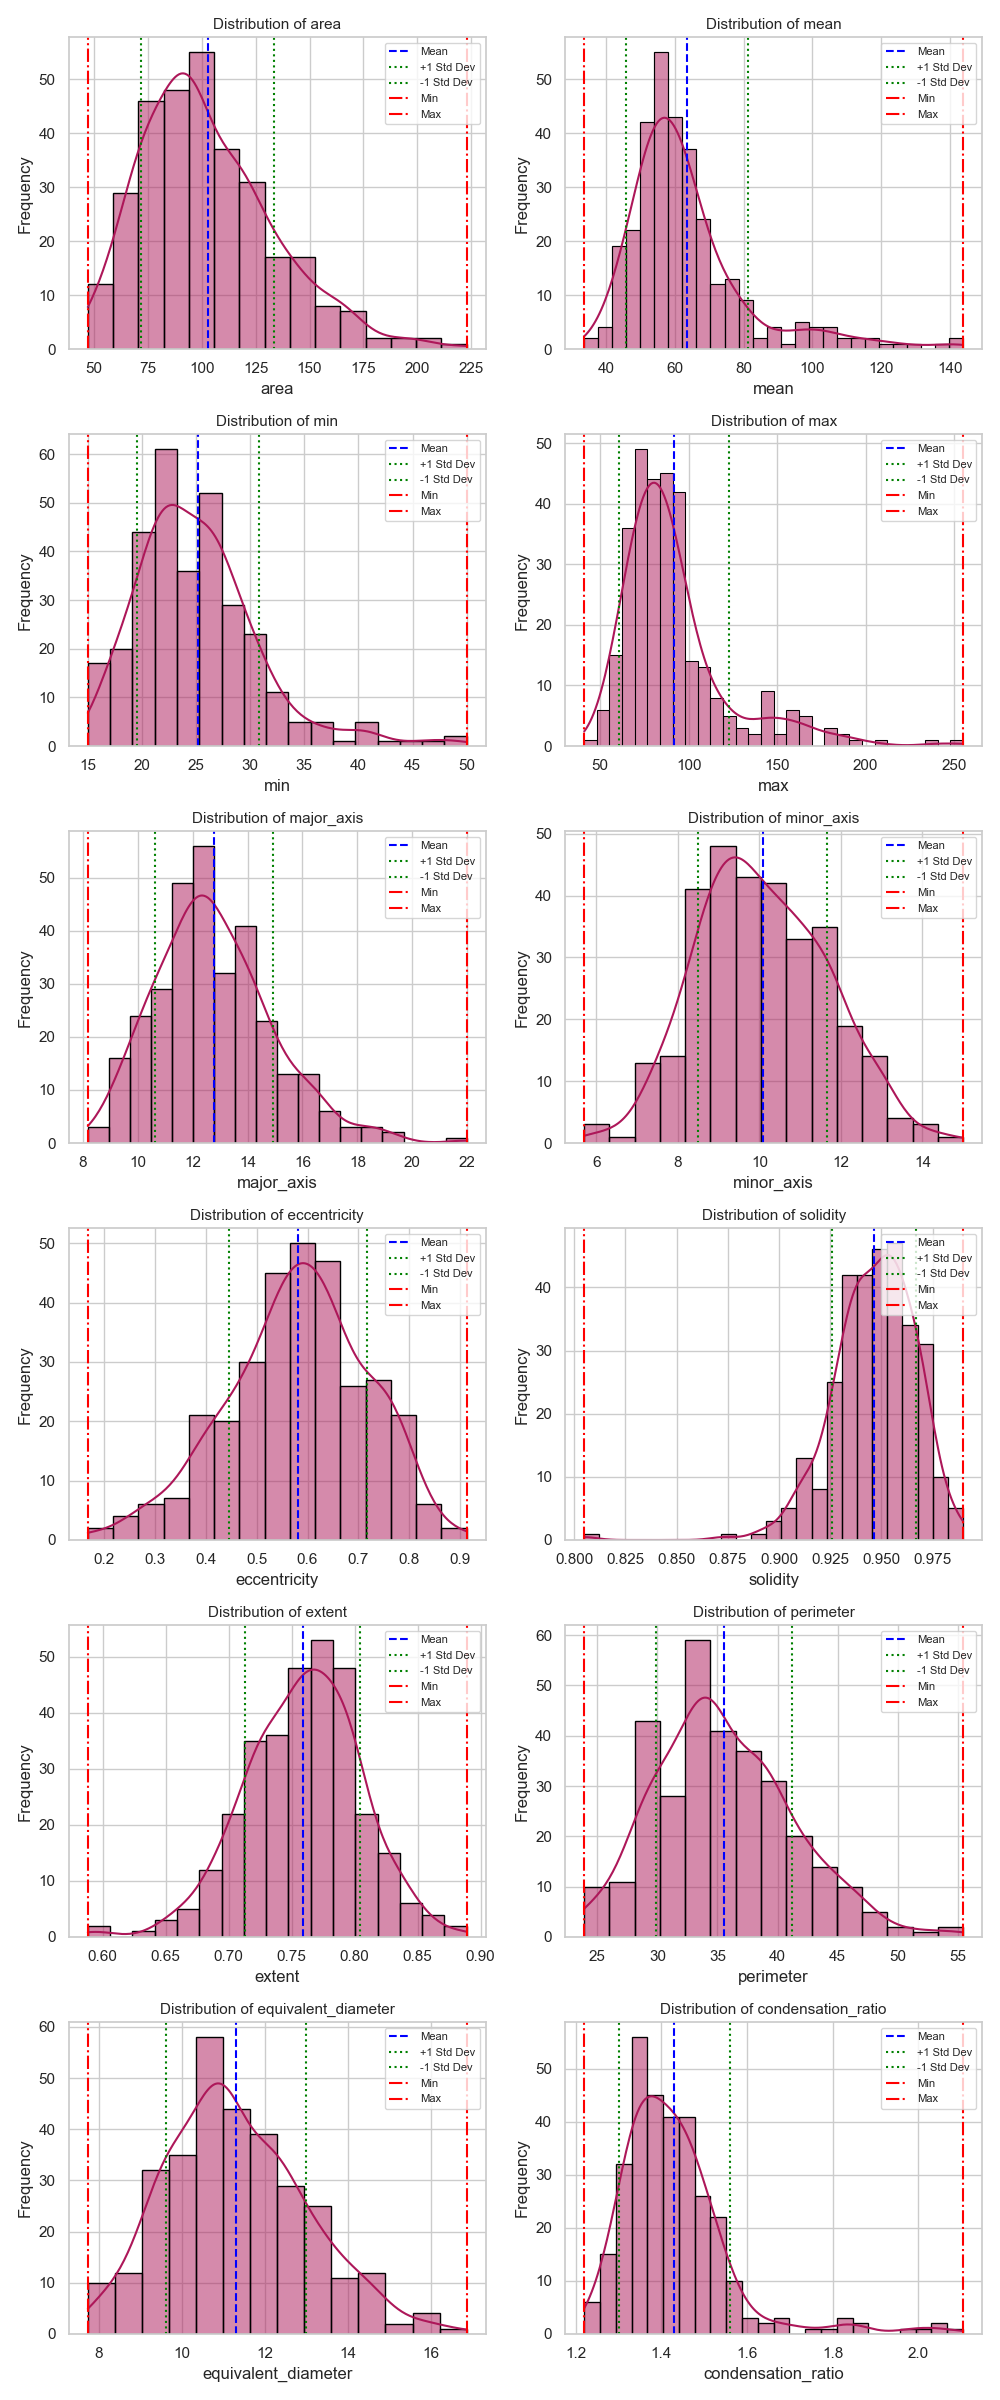

In [14]:
# Set Seaborn style and color palette
sns.set(style='whitegrid')
rocket_palette = sns.color_palette('rocket')
highlight_color = rocket_palette[2]

# Number of plots per row
cols = 2
rows = int(np.ceil(len(numerical_columns) / cols))

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

# Plot each feature
for i, col in enumerate(numerical_columns):
    ax = axes[i]
    sns.histplot(df[col], kde=True, color=highlight_color, edgecolor='black', ax=ax)
    
    # Calculate stats
    mean = df[col].mean()
    std = df[col].std()
    min_val = df[col].min()
    max_val = df[col].max()
    
    # Add vertical lines for mean, std, min, max
    ax.axvline(mean, color='blue', linestyle='--', label='Mean')
    ax.axvline(mean + std, color='green', linestyle=':', label='+1 Std Dev')
    ax.axvline(mean - std, color='green', linestyle=':', label='-1 Std Dev')
    ax.axvline(min_val, color='red', linestyle='-.', label='Min')
    ax.axvline(max_val, color='red', linestyle='-.', label='Max')

    ax.set_title(f"Distribution of {col}", fontsize=11)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.legend(fontsize=8, loc='upper right')

# Remove empty subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Interesting to see the overall distribution of the features, but it is also a bit overwhelming. Maybe we can look at the correlation matrix to figure out feature correlation.

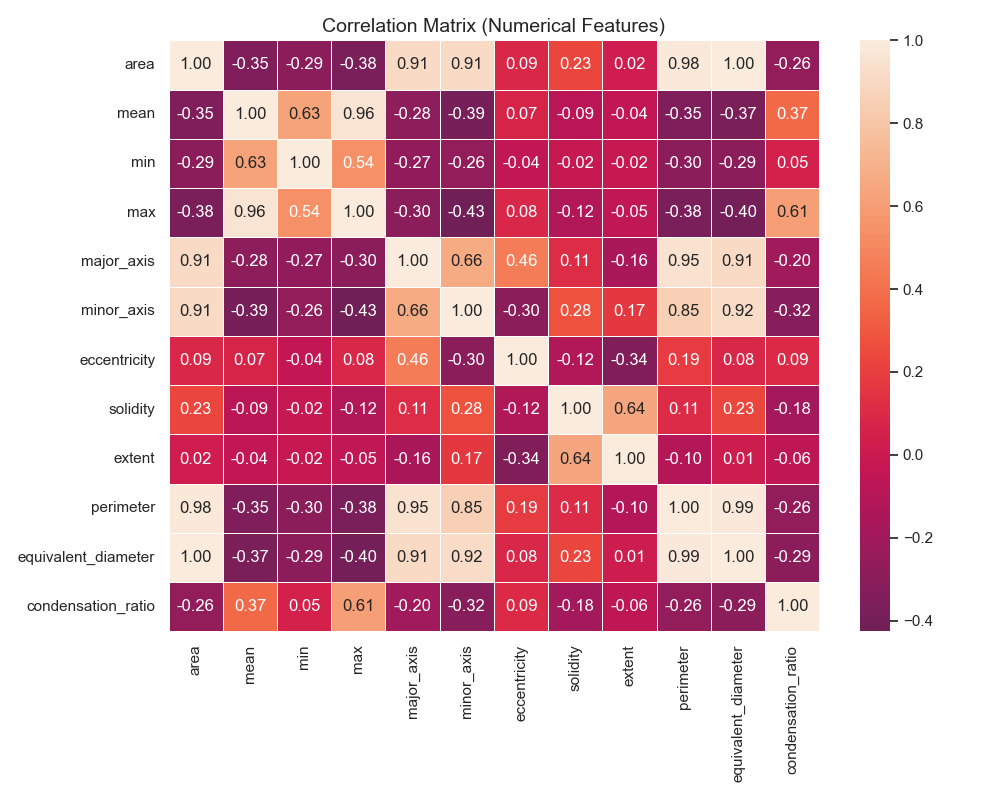

In [15]:
plt.figure(figsize=(10, 8))
corr = df[numerical_columns].corr()
sns.heatmap(corr, annot=True, cmap='rocket', center=0, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Numerical Features)", fontsize=14)
plt.tight_layout()
plt.show()

Here, we can see nicely that size-based measurements like `area` correlate higher to other size-based measurements like `equivalent_diameter` or `major_axis` than to shape- or intensity-based measurements. This can also be seen in the other categories. If you want to find out more about how to group measurements into these categories, you can have a look at this [blog post](https://focalplane.biologists.com/2023/05/03/feature-extraction-in-napari/) I wrote some time ago.

## Part 6) Visualization

### Categorical: Mitotic Phase Classification

As this dataset does not have a time component, let us try to classify mitotic phases using intensity-, shape- and size-based measurements. Specifically, let us select four biologically relevant features: area, eccentricity, condensation ratio, and solidity. These features are known to change during the progression of mitosis as the nucleus condenses, elongates, and eventually divides.

In [16]:
# Select features for clustering
features = ['area', 'eccentricity', 'condensation_ratio', 'solidity']
X = df[features]

# Cluster into 4 groups
kmeans = KMeans(n_clusters=4, random_state=42)
df['predicted_phase'] = kmeans.fit_predict(X)

# Inspect the cluster centers to guide biological relabeling
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=features)
print("\nCluster Centers:\n", centroids)


Cluster Centers:
          area  eccentricity  condensation_ratio  solidity
0   95.043478      0.573187            1.413551  0.943508
1  125.500000      0.575450            1.397132  0.951818
2  168.785714      0.630123            1.408825  0.953877
3   69.252874      0.579699            1.491900  0.942376


Let us use the KMeans cluster centroids to assign each cluster to a biological mitotic phase. By inspecting the values of area, eccentricity, condensation_ratio, and solidity, we can infer the most likely phase represented by each cluster:

- Cluster 3 shows the highest condensation ratio and the smallest area, which strongly suggests **metaphase**, where chromosomes are maximally condensed and aligned.
- Cluster 0 has intermediate values for area and condensation ratio, which corresponds well to **prophase**, when chromatin begins to condense.
- Cluster 1 shows higher solidity and intermediate area, which fits **telophase**, where chromatin is de-condensing and nuclei are reforming.
- Cluster 2 has the largest area and the highest eccentricity, consistent with **anaphase**, when the chromatin is stretched as chromatids separate.

Based on this reasoning, we mapped:
- Cluster 0 → prophase  
- Cluster 1 → telophase  
- Cluster 2 → anaphase  
- Cluster 3 → metaphase

Since the relationship between these features is not strictly linear or sequential, a pair plot is a suitable visualization method. It allows us to examine pairwise distributions and interactions between multiple variables simultaneously while also visualizing how these relationships differ across the predicted mitotic phases. This enables the identification of clusters, trends, or overlaps in feature space that correspond to different biological states. By color-coding points according to the predicted phase, we can visually assess how well the features separate the phases and identify which combinations provide the clearest differentiation.

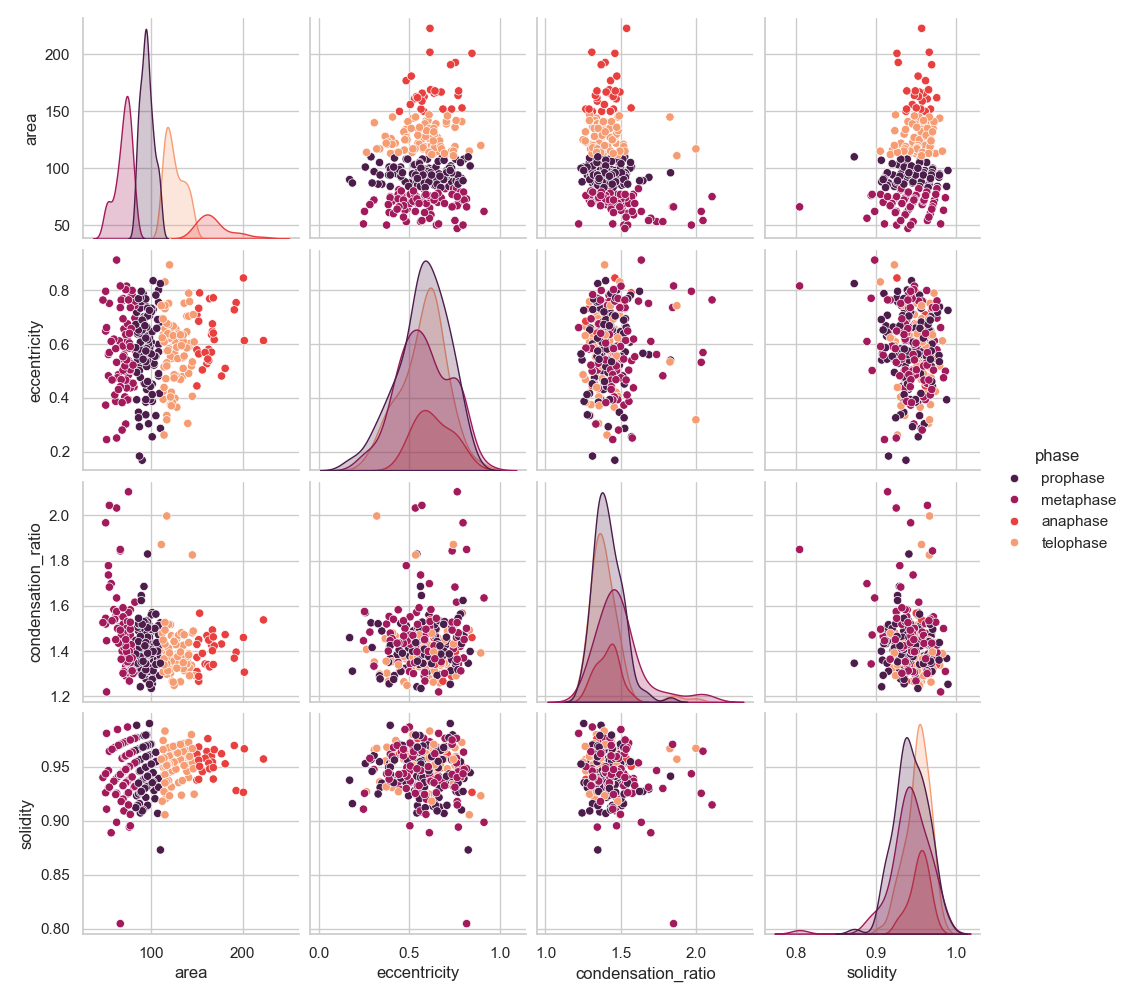

In [17]:
# Apply biological label mapping based on actual centroid values
corrected_map = {
    0: 'prophase',
    1: 'telophase',
    2: 'anaphase',
    3: 'metaphase'
}
df['phase'] = df['predicted_phase'].map(corrected_map)

# Define the biological order explicitly
phase_order = ['prophase', 'metaphase', 'anaphase', 'telophase']
df['phase'] = pd.Categorical(df['phase'], categories=phase_order, ordered=True)

# Create a new DataFrame with labeled phases
plot_df = df[features + ['phase']]

# Use the same color palette and plot
sns.pairplot(plot_df, hue='phase', vars=features, palette='rocket', hue_order=phase_order)
plt.show()

As our new category `phase` is categorical, we can plot how often each category occurs in the dataset.

1992866191.py (6): 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



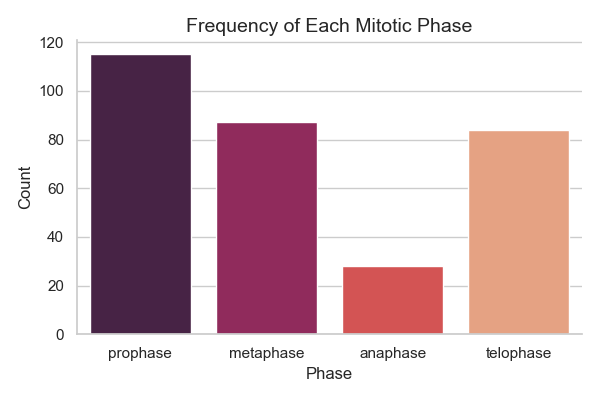

In [18]:
# Count occurrences of each phase
phase_counts = df['phase'].value_counts().reindex(phase_order)

# Plot the counts
plt.figure(figsize=(6, 4))
sns.barplot(x=phase_counts.index, y=phase_counts.values, palette='rocket')

# Title and labels
plt.title('Frequency of Each Mitotic Phase', fontsize=14)
plt.xlabel('Phase', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Optional cleanup
sns.despine()  # removes the top and right border
plt.tight_layout()  # adjusts spacing to avoid overflow
plt.show()

Most of the cells in the image are found in **prophase**, with fewer in **metaphase** and **telophase**, and only a few in **anaphase**. This distribution reflects the relative duration of each mitotic phase. Prophase is the longest stage of mitosis, during which chromosomes condense and the mitotic spindle begins to form, making it more likely to observe cells in this phase in a static snapshot. In contrast, **anaphase is very short**, as sister chromatids are rapidly pulled apart, which explains why it is less frequently captured in fixed images. Therefore, the observed phase frequencies are consistent with the expected dynamics of the cell cycle.

 Now, it would still be very interesting to see the spatial distribution of the different phases. Therefore, we map our original image as well as a label image with the four phases next to each other.

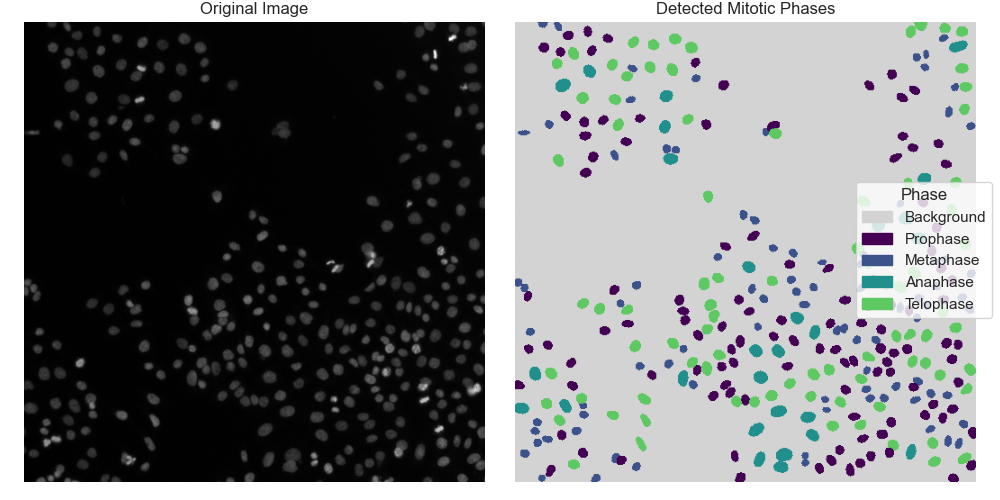

In [19]:
# Create a label image for visualization
phase_label_image = np.zeros_like(labels, dtype=np.int32)

# Map each region's phase label to the corresponding pixels in the label image
for region, phase_label in zip(properties, df['phase'].cat.codes):
    phase_label_image[tuple(region.coords.T)] = phase_label + 1  # Add 1 to avoid 0 for background

# Resize phase label image to match original image shape (if necessary)
if phase_label_image.shape != image.shape:
    phase_label_image = resize(phase_label_image, image.shape, order=0, preserve_range=True, anti_aliasing=False).astype(np.int32)

# Define a qualitative colormap for categorical phases
phase_colors = ['lightgray', '#440154', '#3b528b', '#21908d', '#5ec962']  # 0=background, 1-4=phases
cmap = ListedColormap(phase_colors)

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Show the original image
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# Show the phase label image
im = ax[1].imshow(phase_label_image, cmap=cmap, vmin=0, vmax=4)
ax[1].set_title('Detected Mitotic Phases')
ax[1].axis('off')

# Custom legend for categorical labels
from matplotlib.patches import Patch
legend_labels = ['Background', 'Prophase', 'Metaphase', 'Anaphase', 'Telophase']
legend_colors = [Patch(color=col, label=lab) for col, lab in zip(phase_colors, legend_labels)]
fig.legend(handles=legend_colors, loc='center right', title='Phase')

plt.tight_layout()
plt.show()

This looks biologically reasonable, even though some labels could be swapped, especially between pro- and metaphase as well as ana- and telophase. 

## Part 7) Bonus: Highlight

Let us use an "expert annotation" for mitotic phases as a reference to evaluate our clustering-based classification. This allows us to investigate where the automated pipeline performs well and where it diverges from expert judgment, revealing strengths and limitations of our approach.

In [20]:
df.head()

,area,mean,min,max,major_axis,minor_axis,centroid,coords,eccentricity,solidity,extent,perimeter,equivalent_diameter,condensation_ratio,UMAP_0,UMAP_1,predicted_phase,phase
0,101.0,122.108911,48.0,162.0,12.032226,10.737512,"(114.42574257425743, 211.990099009901)","[[109, 211], [109, 212], [110, 208], [110, 209...",0.451253,0.935185,0.765152,35.556349,11.340070,1.326685,10.147720,3.231089,0,prophase
1,122.0,79.008197,41.0,116.0,13.078726,11.861871,"(468.1639344262295, 463.5245901639344)","[[462, 462], [462, 463], [462, 464], [463, 460...",0.421219,0.960630,0.782051,38.384776,12.463355,1.468202,4.937494,5.902939,1,telophase
2,163.0,56.484663,17.0,82.0,15.988471,13.014338,"(366.1042944785276, 291.9447852760736)","[[359, 289], [359, 290], [359, 291], [359, 292...",0.580889,0.958824,0.724444,45.455844,14.406181,1.451722,0.568982,6.083708,2,anaphase
3,126.0,68.761905,27.0,94.0,13.241216,12.144300,"(386.76190476190476, 348.3174603174603)","[[381, 345], [381, 346], [381, 347], [381, 348...",0.398522,0.954545,0.807692,39.556349,12.666025,1.367036,3.463878,6.905309,1,telophase
4,134.0,62.201493,23.0,85.0,13.938847,12.235981,"(415.6194029850746, 284.5)","[[410, 282], [410, 283], [410, 284], [410, 285...",0.478967,0.964029,0.797619,40.384776,13.061933,1.366527,2.428976,7.006569,1,telophase


In [21]:
annotation = imread('../data/mitotic_phase_annotation.tif')

stackview.curtain(phase_label_image, annotation)

In [24]:
# Function to map pixel value to phase
def map_annotation(value):
    return {
        1: 'prophase',
        2: 'metaphase',
        3: 'anaphase',
        4: 'telophase'
    }.get(value, np.nan)

# Extract the expert phase per region via centroid
expert_phases = []

for centroid in df['centroid']:
    # Round centroid to nearest integer coordinates
    row, col = map(int, np.round(centroid))
    
    # Boundary check (if centroid slightly out of image)
    if (0 <= row < annotation.shape[0]) and (0 <= col < annotation.shape[1]):
        annotation_val = annotation[row, col]
    else:
        annotation_val = 0  # treat as unannotated
    
    expert_phases.append(map_annotation(annotation_val))

# Add to DataFrame
df['expert_phase'] = expert_phases

In [25]:
df

,area,mean,min,max,major_axis,minor_axis,centroid,coords,eccentricity,solidity,extent,perimeter,equivalent_diameter,condensation_ratio,UMAP_0,UMAP_1,predicted_phase,phase,expert_phase
0,101.0,122.108911,48.0,162.0,12.032226,10.737512,"(114.42574257425743, 211.990099009901)","[[109, 211], [109, 212], [110, 208], [110, 209...",0.451253,0.935185,0.765152,35.556349,11.340070,1.326685,10.147720,3.231089,0,prophase,metaphase
1,122.0,79.008197,41.0,116.0,13.078726,11.861871,"(468.1639344262295, 463.5245901639344)","[[462, 462], [462, 463], [462, 464], [463, 460...",0.421219,0.960630,0.782051,38.384776,12.463355,1.468202,4.937494,5.902939,1,telophase,telophase
2,163.0,56.484663,17.0,82.0,15.988471,13.014338,"(366.1042944785276, 291.9447852760736)","[[359, 289], [359, 290], [359, 291], [359, 292...",0.580889,0.958824,0.724444,45.455844,14.406181,1.451722,0.568982,6.083708,2,anaphase,NaN
3,126.0,68.761905,27.0,94.0,13.241216,12.144300,"(386.76190476190476, 348.3174603174603)","[[381, 345], [381, 346], [381, 347], [381, 348...",0.398522,0.954545,0.807692,39.556349,12.666025,1.367036,3.463878,6.905309,1,telophase,NaN
4,134.0,62.201493,23.0,85.0,13.938847,12.235981,"(415.6194029850746, 284.5)","[[410, 282], [410, 283], [410, 284], [410, 285...",0.478967,0.964029,0.797619,40.384776,13.061933,1.366527,2.428976,7.006569,1,telophase,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,66.0,67.590909,17.0,125.0,12.720376,7.349540,"(484.59090909090907, 110.68181818181819)","[[480, 110], [480, 111], [480, 112], [480, 113...",0.816195,0.804878,0.600000,33.384776,9.166996,1.849361,10.363921,6.648078,3,metaphase,NaN
310,98.0,73.387755,41.0,92.0,13.579750,9.344366,"(456.7959183673469, 507.46938775510205)","[[451, 506], [451, 507], [451, 508], [451, 509...",0.725606,0.989899,0.837607,34.727922,11.170384,1.253615,6.250813,8.516868,0,prophase,NaN
311,62.0,58.709677,25.0,96.0,13.929175,5.702378,"(123.59677419354838, 9.403225806451612)","[[121, 8], [121, 10], [121, 11], [121, 12], [1...",0.912362,0.898551,0.738095,32.142136,8.884866,1.635165,9.567328,8.098370,3,metaphase,metaphase
312,51.0,33.607843,16.0,41.0,9.291052,6.968932,"(122.96078431372548, 277.80392156862746)","[[119, 276], [119, 277], [119, 278], [119, 279...",0.661359,0.980769,0.809524,23.899495,8.058239,1.219953,5.353026,11.993237,3,metaphase,NaN


In [ ]:
# Filter annotated data
eval_df = df.dropna(subset=['expert_phase'])

# Print how many annotated examples we have
print(f"Number of annotated nuclei: {len(eval_df)}\n")

# Class distribution
print("Expert class distribution:\n", eval_df['expert_phase'].value_counts())
print("\nKMeans class distribution:\n", eval_df['phase'].value_counts())

# Classification report
print("\nClassification Report:")
print(classification_report(eval_df['expert_phase'], eval_df['phase']))

Number of annotated nuclei: 99

Expert class distribution:
 expert_phase
prophase     33
metaphase    31
telophase    19
anaphase     16
Name: count, dtype: int64

KMeans class distribution:
 phase
prophase     37
metaphase    24
telophase    20
anaphase     18
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

    anaphase       0.89      1.00      0.94        16
   metaphase       1.00      0.77      0.87        31
    prophase       0.81      0.91      0.86        33
   telophase       0.85      0.89      0.87        19

    accuracy                           0.88        99
   macro avg       0.89      0.89      0.89        99
weighted avg       0.89      0.88      0.88        99



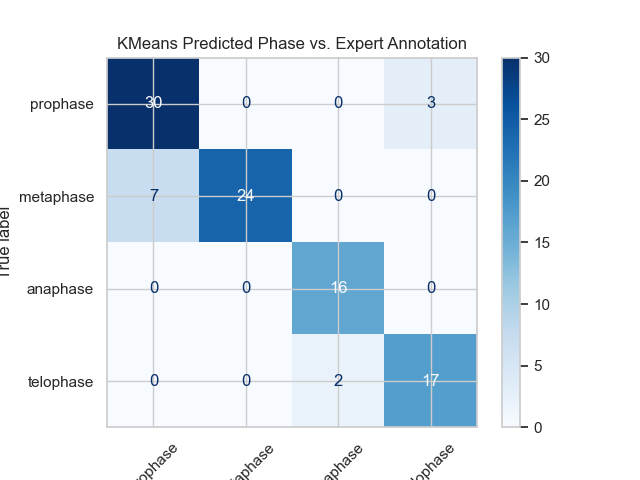

In [27]:
phases = ["prophase", "metaphase", "anaphase", "telophase"]
cm = confusion_matrix(eval_df['expert_phase'], eval_df['phase'], labels=phases)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=phases)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("KMeans Predicted Phase vs. Expert Annotation")
plt.show()

## Outlook

__Hypothesis 2:__ The number of neighboring cells that are in the same phase of mitosis is higher in certain regions of the image, indicating a spatial correlation between cell cycle progression. For this we can use `centroid` and `coords`, first idea: